# Patient Selection for Diabetes Drug Testing

In [1]:
from time import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score, average_precision_score, fbeta_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import aequitas as ae
import visuals as vs
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable, select_first_encounter, reduce_dimension_ndc, patient_dataset_splitter_tf, create_tf_categorical_feature_cols, get_mean_std_from_preds, get_binary_prediction
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Part 1. EDA

### Dataset Loading and Schema Review

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


### Determine Level of Dataset

In [4]:
# the dataset is at the line level because the number of rows is greater than the number of unique encounters
df.shape, df.encounter_id.nunique(), df.patient_nbr.nunique()

((143424, 26), 101766, 71518)

### Analyze Dataset

In [5]:
df = df.replace('?', np.nan).replace('None', np.nan)

In [6]:
# weight, 'max_glu_serum', 'A1Cresult', medical_specialty, payer_code, and ndc_code 
# have a high percentage of null values
df.isnull().mean().sort_values(ascending=False)

weight                      0.970005
max_glu_serum               0.951089
A1Cresult                   0.820295
medical_specialty           0.484319
payer_code                  0.377831
ndc_code                    0.163585
race                        0.023071
primary_diagnosis_code      0.000230
patient_nbr                 0.000000
gender                      0.000000
age                         0.000000
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
readmitted                  0.000000
change                      0.000000
other_diagnosis_codes       0.000000
number_outpatient           0.000000
number_inpatient            0.000000
number_emergency            0.000000
num_lab_procedures          0.000000
number_diagnoses            0.000000
num_medications             0.000000
num_procedures              0.000000
encounter_id                0.000000
dtype: float64

In [7]:
# remove columns with high null percentage
df = df.drop(columns = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   admission_type_id         143424 non-null  int64 
 6   discharge_disposition_id  143424 non-null  int64 
 7   admission_source_id       143424 non-null  int64 
 8   time_in_hospital          143424 non-null  int64 
 9   primary_diagnosis_code    143391 non-null  object
 10  other_diagnosis_codes     143424 non-null  object
 11  number_outpatient         143424 non-null  int64 
 12  number_inpatient          143424 non-null  int64 
 13  number_emergency          143424 non-null  int64 
 14  num_

In [9]:
# identify categorical columns
cat_col = list(df.select_dtypes(['object']).columns)
cat_col.extend(['admission_type_id','discharge_disposition_id', 'admission_source_id'])
for col in cat_col:
    df[col] = df[col].astype(str)

In [10]:
# high cardinality columns include 'other_diagnosis_codes', 'primary_diagnosis_code', 'ndc_code'
cat_df = df[cat_col]
cardinality_df = pd.DataFrame({'columns': cat_df.columns, 'cardinality': cat_df.nunique() } )
cardinality_df.sort_values('cardinality', ascending=False)

,columns,cardinality
other_diagnosis_codes,other_diagnosis_codes,19374
primary_diagnosis_code,primary_diagnosis_code,717
ndc_code,ndc_code,252
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
age,age,10
admission_type_id,admission_type_id,8
race,race,6
gender,gender,3
readmitted,readmitted,3


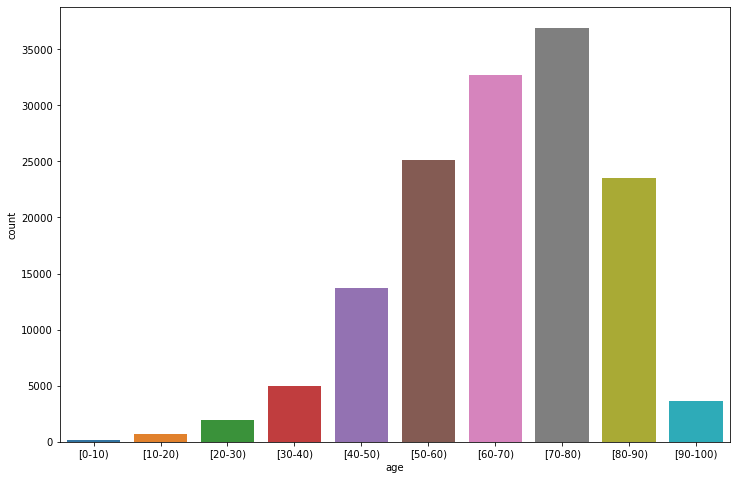

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(x='age', data=df); 

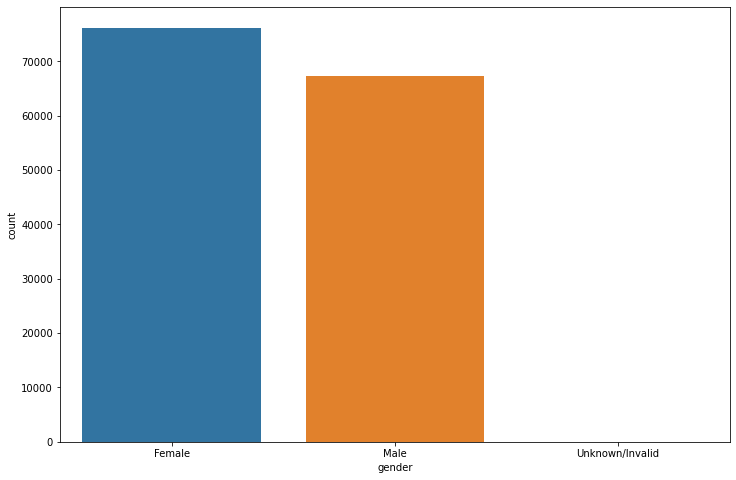

In [12]:
plt.figure(figsize=(12, 8))
sns.countplot(x='gender', data=df); 

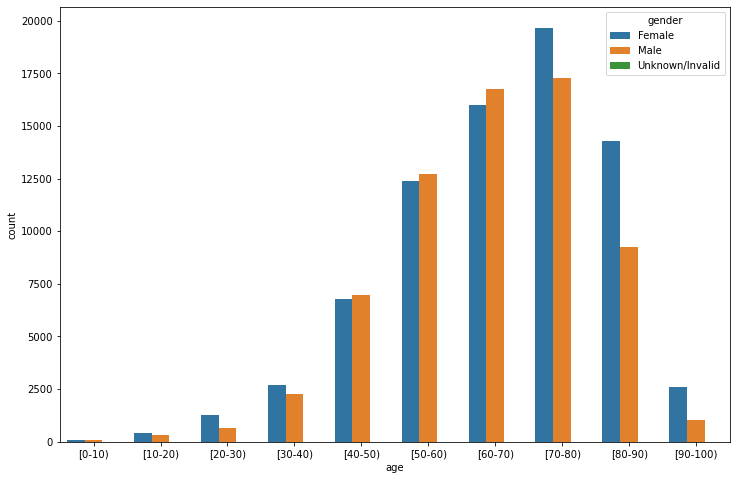

In [13]:
# distribution of age and gender
plt.figure(figsize=(12, 8))
sns.countplot(x="age", hue="gender", data=df); 

In [14]:
df.select_dtypes(['int64']).columns

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures'],
      dtype='object')

In [15]:
num_col = ['time_in_hospital', 
           'number_outpatient',
           'number_inpatient', 
           'number_emergency', 
           'num_lab_procedures',
           'number_diagnoses', 
           'num_medications', 
           'num_procedures']
df[num_col].describe()

,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


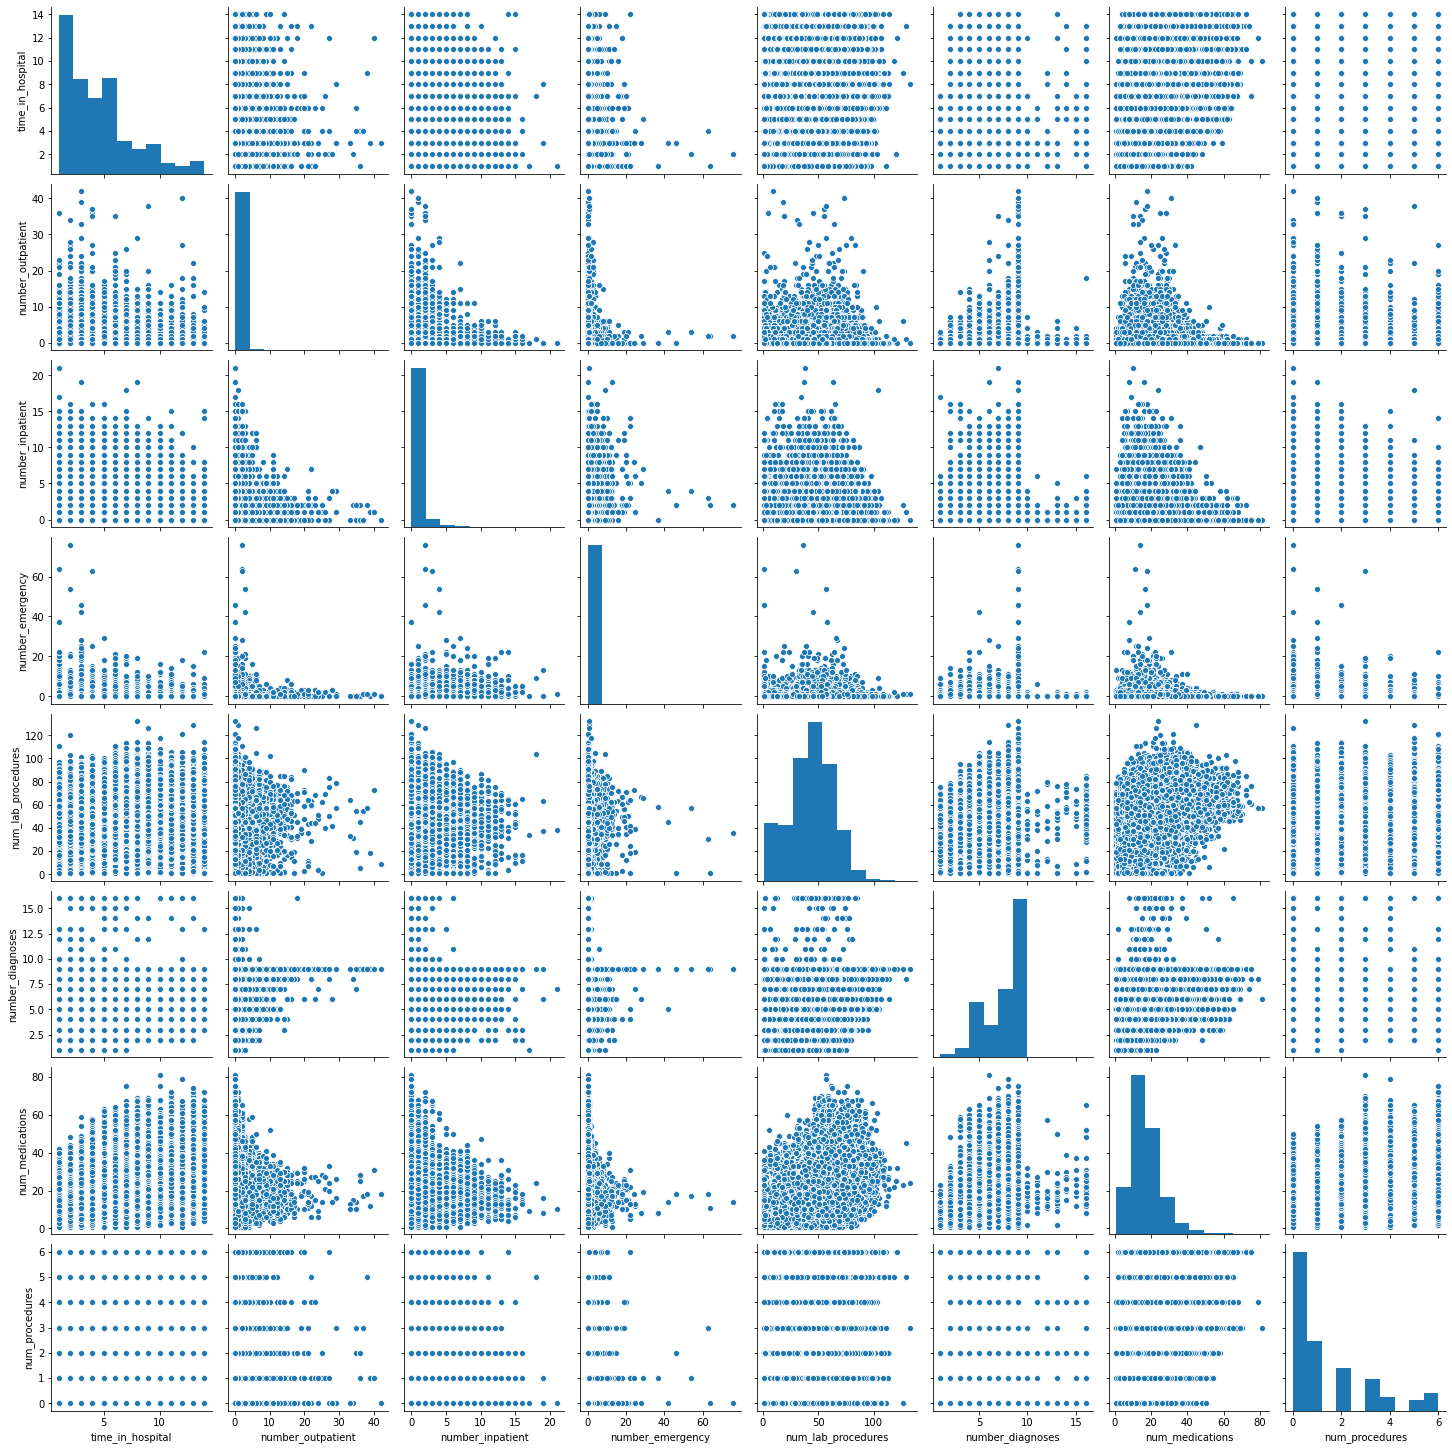

In [16]:
# num_medications and num_lab_procecures follows normal distribution
sns.pairplot(df[num_col]);

### Reduce Dimensionality of the NDC Code Feature

In [17]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [18]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,Ch,>30,Human Insulin
1,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,Ch,NO,Human Insulin
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,Ch,NO,Human Insulin
3,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,434,198|486,0,0,0,33,8,18,3,Ch,NO,Human Insulin
4,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,250.7,403|996,0,0,0,47,9,17,2,No,>30,Human Insulin


In [19]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

### Aggregate Dataset and Select First Encounter for each Patient 

In [20]:
# aggregate lines into encounter
non_grouped_field_list = ['generic_drug_name']
grouped_field_list = ['encounter_id', 'patient_nbr']
encounter_df = reduce_dim_df.groupby(grouped_field_list)[non_grouped_field_list] \
                            .agg(lambda x: '|'.join([y for y in x if y is not np.nan ])) \
                            .reset_index()
encounter_df.head()

,encounter_id,patient_nbr,generic_drug_name
0,12522,48330783,Glipizide|Human Insulin
1,15738,63555939,Human Insulin|Rosiglitazone Maleate
2,16680,42519267,Human Insulin|Glipizide
3,28236,89869032,Human Insulin
4,35754,82637451,Human Insulin


In [21]:
# add the rest of the columns
col = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'primary_diagnosis_code', 'other_diagnosis_codes',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures', 'change', 'readmitted']

encounter_df = pd.merge(reduce_dim_df[col], encounter_df, on=['encounter_id', 'patient_nbr'], how='left')
encounter_df.drop_duplicates(subset=col, inplace=True)
encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,Ch,>30,Human Insulin
1,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,Ch,NO,Human Insulin
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,Ch,NO,Human Insulin|Glipizide
3,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,434,198|486,0,0,0,33,8,18,3,Ch,NO,Human Insulin|Rosiglitazone Maleate
4,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,250.7,403|996,0,0,0,47,9,17,2,No,>30,Human Insulin


In [22]:
first_encounter_df = select_first_encounter(encounter_df)
first_encounter_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,Ch,<30,Human Insulin|Metformin Hcl|Glyburide
1,729,189899286,Caucasian,Female,[80-90),1,3,7,4,820,493|E880,0,0,0,68,9,23,2,No,NO,Metformin Hcl
2,774,64331490,Caucasian,Female,[80-90),1,1,7,3,274,427|416,0,0,0,46,9,20,0,Ch,NO,Glyburide|Metformin Hcl
3,927,14824206,AfricanAmerican,Female,[30-40),1,1,7,5,590,220|250,0,0,0,49,3,5,0,No,NO,Glimepiride
4,1152,8380170,AfricanAmerican,Female,[50-60),1,1,7,6,282,250.01|?,0,1,0,43,2,13,2,No,>30,Human Insulin


In [23]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


### One Hot Code

In [24]:
# first_encounter_df has alrady been aggregated in the previous step
agg_drug_df = first_encounter_df.copy()
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,Ch,<30,Human Insulin|Metformin Hcl|Glyburide
1,729,189899286,Caucasian,Female,[80-90),1,3,7,4,820,493|E880,0,0,0,68,9,23,2,No,NO,Metformin Hcl
2,774,64331490,Caucasian,Female,[80-90),1,1,7,3,274,427|416,0,0,0,46,9,20,0,Ch,NO,Glyburide|Metformin Hcl
3,927,14824206,AfricanAmerican,Female,[30-40),1,1,7,5,590,220|250,0,0,0,49,3,5,0,No,NO,Glimepiride
4,1152,8380170,AfricanAmerican,Female,[50-60),1,1,7,6,282,250.01|?,0,1,0,43,2,13,2,No,>30,Human Insulin


In [25]:
# normalize num_col
num_col.remove('time_in_hospital')
scaler = StandardScaler()
normalized_num_col = ['normalized_' + col for col in num_col]
scaled_data = pd.DataFrame(scaler.fit_transform(agg_drug_df[num_col]), columns=normalized_num_col)
agg_drug_df = pd.concat([agg_drug_df, scaled_data], axis=1)

In [26]:
ndc_col_list = sorted(reduce_dim_df.generic_drug_name.unique())
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide And Metformin Hcl',
 'Glyburide',
 'Glyburide And Metformin Hydrochloride',
 'Human Insulin',
 'Metformin Hcl',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole And Metformin Hydrochloride',
 'Pioglitazone',
 'Pioglitazone And Glimepiride',
 'Pioglitazone Hydrochloride And Glimepiride',
 'Repaglinide',
 'Rosiglitazone Maleate',
 'Tolazamide',
 'Tolbutamide']

In [27]:
# one hot code 'generic_drug_name'
for col in ndc_col_list:
    agg_drug_df[col]  = agg_drug_df['generic_drug_name'].apply(lambda x: 1 if col in x else 0)

In [28]:
other_dx_code = []
for x in agg_drug_df.other_diagnosis_codes.unique():
    other_dx_code.extend(x.split('|'))
other_dx_code = set(other_dx_code)
pri_dx_code = set(agg_drug_df.primary_diagnosis_code.unique())
dx_code = list(other_dx_code.union(pri_dx_code))
dx_code = sorted(set([x.split('.')[0] for x in dx_code if (x !='?') & (type(x) == type('12'))]))

In [29]:
# one hot code 'dx_code'
agg_drug_df['dx_code'] = agg_drug_df.other_diagnosis_codes + '|' + agg_drug_df.primary_diagnosis_code
agg_drug_df['dx_code'] = agg_drug_df['dx_code'].astype(str)
for col in dx_code:
    agg_drug_df[col]  = agg_drug_df['dx_code'].apply(lambda x: 1 if col in x else 0)

In [30]:
def one_hot_code(col, df):
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies.iloc[:, :-1]], axis=1)
    return (dummies.columns[:-1], df)

In [31]:
# one hot code the rest of the categorical variables
one_hot_col = []
for col in ['race','gender','age', 'change','readmitted','admission_type_id','discharge_disposition_id', 'admission_source_id']:
    col_name_list, agg_drug_df = one_hot_code(col, agg_drug_df)
    one_hot_col.extend(col_name_list)  

In [32]:
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name,normalized_number_outpatient,normalized_number_inpatient,normalized_number_emergency,normalized_num_lab_procedures,normalized_number_diagnoses,normalized_num_medications,normalized_num_procedures,Acarbose,Glimepiride,Glipizide,Glipizide And Metformin Hcl,Glyburide,Glyburide And Metformin Hydrochloride,Human Insulin,Metformin Hcl,Miglitol,Nateglinide,Pioglitazole And Metformin Hydrochloride,Pioglitazone,Pioglitazone And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Repaglinide,Rosiglitazone Maleate,Tolazamide,Tolbutamide,dx_code,10,11,110,112,114,115,117,122,123,130,131,133,135,136,137,138,139,14,140,141,142,143,145,146,147,149,150,151,152,153,154,155,156,157,158,160,161,162,163,164,17,170,171,172,173,174,175,179,180,182,183,184,185,186,187,188,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,208,210,211,212,214,215,216,217,218,219,220,223,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,243,244,245,246,250,251,252,253,255,256,258,259,260,261,262,263,265,266,268,269,27,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,3,300,301,303,304,305,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,320,322,323,324,325,327,331,332,333,334,335,336,337,338,34,340,341,342,343,344,345,346,347,348,349,35,350,351,352,353,354,...,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,927,928,933,934,935,936,94,941,942,943,944,945,948,952,953,955,956,957,958,959,962,963,964,965,966,967,968,969,970,971,972,976,977,980,983,986,987,988,989,990,991,992,994,995,996,997,998,999,E812,E814,E816,E817,E818,E819,E821,E822,E825,E826,E828,E829,E849,E850,E853,E854,E855,E858,E868,E870,E878,E879,E880,E881,E882,E883,E884,E885,E886,E887,E888,E890,E894,E900,E904,E905,E906,E909,E915,E916,E917,E918,E919,E920,E922,E924,E927,E928,E929,E930,E931,E932,E933,E934,E935,E936,E937,E938,E939,E941,E942,E944,E946,E947,E949,E950,E955,E956,E965,E966,E968,E980,V01,V02,V03,V06,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V23,V25,V27,V42,V43,V44,V45,V46,V49,V51,V53,V54,V55,V56,V57,V58,V60,V61,V62,V63,V64,V65,V66,V67,V70,V71,V72,V85,V86,nan,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),change_Ch,readmitted_<30,readmitted_>30,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_2,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,Ch,<30,Human Insulin|Metformin Hcl|Gl

In [33]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Part 2. Prepare Fields and Cast Dataset

### Feature Selection

In [34]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [35]:
cat_col_list = ndc_col_list + dx_code + one_hot_col 
num_col_list = normalized_num_col
PREDICTOR_FIELD = 'time_in_hospital'
selected_features_df_sklearn = select_model_features(agg_drug_df, cat_col_list, num_col_list, PREDICTOR_FIELD)

In [36]:
cat_col_list =  ['generic_drug_name', 
                 'race',
                 'gender',
                 'age',
                 'primary_diagnosis_code',
                 'change',
                 'readmitted',
                 'admission_type_id',
                 'discharge_disposition_id',
                 'admission_source_id']
num_col_list = normalized_num_col
PREDICTOR_FIELD = 'time_in_hospital'
selected_features_df_tf = select_model_features(agg_drug_df, cat_col_list, num_col_list, PREDICTOR_FIELD)

### Preprocess Dataset - Imputing  

The null percentages for the 'weight', 'payer_code', and 'medical_specialty' columns are too high. As a result, they have been removed in a previous data cleaning step. 

In [37]:
processed_df_sklearn = selected_features_df_sklearn.copy()
processed_df_tf = selected_features_df_tf.copy()

### Split Dataset into Train, Validation, and Test Partitions

In [38]:
def patient_dataset_splitter_sklearn(df, patient_key='patient_nbr'):
    
    y = df[PREDICTOR_FIELD].apply(lambda x: 1 if x>=5 else 0)
    X = df.drop(columns=[PREDICTOR_FIELD, patient_key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = patient_dataset_splitter_sklearn(processed_df_sklearn, 'patient_nbr')

In [39]:
d_train, d_val, d_test = patient_dataset_splitter_tf(processed_df_tf, PREDICTOR_FIELD, 'patient_nbr')

In [40]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df_tf)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [41]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


### Demographic Representation Analysis of Split

#### Label Distribution Across Partitions

time_in_hospital
1      7532
2      9473
3     10028
4      7681
5      5566
6      4122
7      3231
8      2419
9      1655
10     1292
11     1054
12      807
13      702
14      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


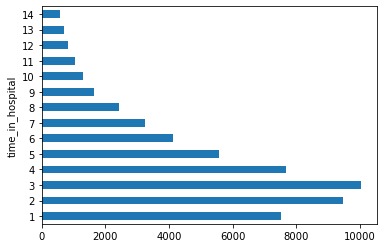

In [42]:
show_group_stats_viz(processed_df_tf, PREDICTOR_FIELD)

time_in_hospital
1     4519
2     5684
3     6017
4     4608
5     3340
6     2473
7     1939
8     1451
9      993
10     775
11     632
12     484
13     421
14     343
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


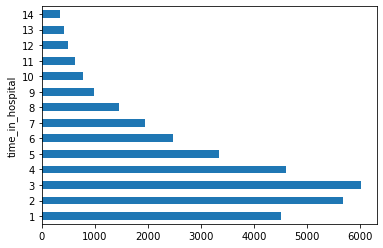

In [43]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1     1506
2     1894
3     2006
4     1537
5     1113
6      825
7      646
8      484
9      331
10     258
11     211
12     162
13     140
14     114
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


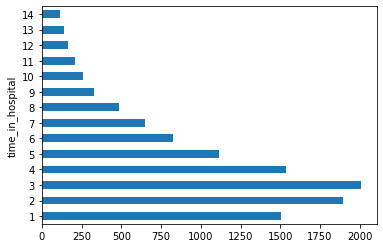

In [44]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

#### Demographic Group Analysis

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


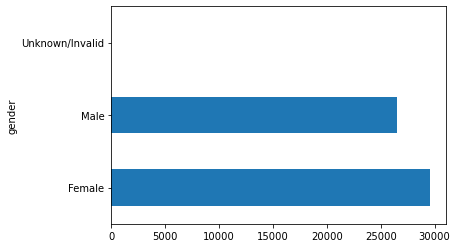

In [45]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df_tf[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17720
Male      15959
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


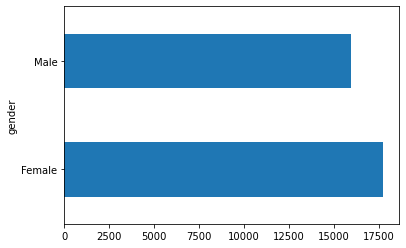

In [46]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             5943
Male               5283
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


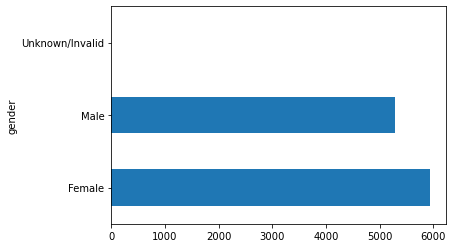

In [47]:
# Test partition
show_group_stats_viz(d_test, 'gender')

### Convert Dataset Splits to TF Dataset

In [48]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [49]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

### Create Categorical Features with TF Feature Columns

#### Build Vocabulary for Categorical Features

In [50]:
vocab_file_list = build_vocab_files(d_train, cat_col_list)

#### Create Categorical Features with Tensorflow Feature Column API

In [51]:
tf_cat_col_list = create_tf_categorical_feature_cols(cat_col_list)

INFO:tensorflow:vocabulary_size = 469 in generic_drug_name is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/generic_drug_name_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 607 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elemen

In [52]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='generic_drug_name', vocabulary_file='./diabetes_vocab/generic_drug_name_vocab.txt', vocabulary_size=469, num_oov_buckets=1, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
t

### Create Numerical Features with TF Feature Columns

In [53]:
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(key=c, default_value=0, dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list
tf_cont_col_list = create_tf_numerical_feature_cols(num_col_list)

In [54]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='normalized_number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=None)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 3.338662  ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.

## Part 3. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

### Use DenseFeatures to combine features for model

In [55]:
claim_feature_columns =tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

### Build Sequential API Model from DenseFeatures and TF Probability Layers

In [56]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [57]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=22)

Train for 264 steps, validate for 88 steps
Epoch 1/22
264/264 [==============================] - 5s 19ms/step - loss: 26.7733 - mse: 26.6967 - val_loss: 20.0419 - val_mse: 19.7084
Epoch 2/22
264/264 [==============================] - 3s 12ms/step - loss: 18.1497 - mse: 17.5891 - val_loss: 16.2534 - val_mse: 15.5228
Epoch 3/22
264/264 [==============================] - 3s 12ms/step - loss: 13.9933 - mse: 13.0846 - val_loss: 11.5125 - val_mse: 10.2622
Epoch 4/22
264/264 [==============================] - 3s 12ms/step - loss: 11.9388 - mse: 10.8308 - val_loss: 10.9919 - val_mse: 10.0284
Epoch 5/22
264/264 [==============================] - 3s 12ms/step - loss: 11.0657 - mse: 10.0522 - val_loss: 10.3186 - val_mse: 9.5384
Epoch 6/22
264/264 [==============================] - 3s 12ms/step - loss: 10.1426 - mse: 9.1971 - val_loss: 9.0022 - val_mse: 8.2353
Epoch 7/22
264/264 [==============================] - 3s 12ms/step - loss: 9.5623 - mse: 8.7367 - val_loss: 10.0022 - val_mse: 9.0106
Epoch

### Show Model Uncertainty Range with TF Probability

In [58]:
feature_list = cat_col_list + num_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [59]:
m, s = get_mean_std_from_preds(diabetes_yhat)

### Show Prediction Output 

In [60]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [61]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,2.870334,3,3.604679,0.698901
1,2.094810,2,2.100161,0.700923
2,3.676713,1,2.391898,0.699981
3,2.261682,3,2.894243,0.699536
4,7.943087,9,7.130151,0.701456


### Convert Regression Output to Classification Output for Patient Selection

In [62]:
binary_prediction = get_binary_prediction(prob_output_df, 'pred_mean', 'actual_value', 5)
binary_prediction.head()

,score,label_value
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1


### Add Binary Prediction to Test Dataframe

In [63]:
def add_pred_to_test(test_df, binary_prediction, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df.reset_index(inplace=True)
    test_df = pd.concat([test_df, binary_prediction], axis=1)
    return test_df

pred_test_df = add_pred_to_test(d_test, binary_prediction, ['race', 'gender'])

In [64]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,40692663,Female,Caucasian,3,0,0
1,70111656,Male,Caucasian,2,0,0
2,24089553,Male,AfricanAmerican,1,0,0
3,14506839,Female,AfricanAmerican,3,0,0
4,964494,Female,Caucasian,9,1,1


### Model Evaluation Metrics

In [65]:
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values
print('accuracy_score:', accuracy_score(y_true, y_pred))
print()
print('f1_score:', f1_score(y_true, y_pred))
print()
print('classification_report:')
print(classification_report(y_true, y_pred))
print()
print('roc_auc_score:', roc_auc_score(y_true, y_pred))

accuracy_score: 0.7457913957424067

f1_score: 0.552383939774153

classification_report:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      6943
           1       0.84      0.41      0.55      4284

    accuracy                           0.75     11227
   macro avg       0.78      0.68      0.69     11227
weighted avg       0.77      0.75      0.72     11227


roc_auc_score: 0.6816952547978719


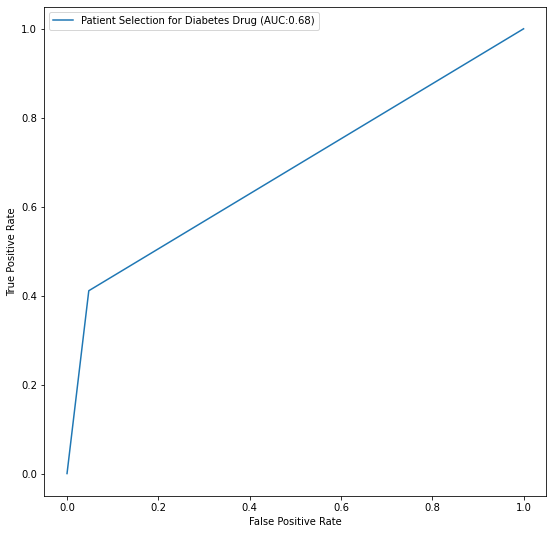

In [66]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Patient Selection for Diabetes Drug', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
plot_auc(y_true, y_pred)

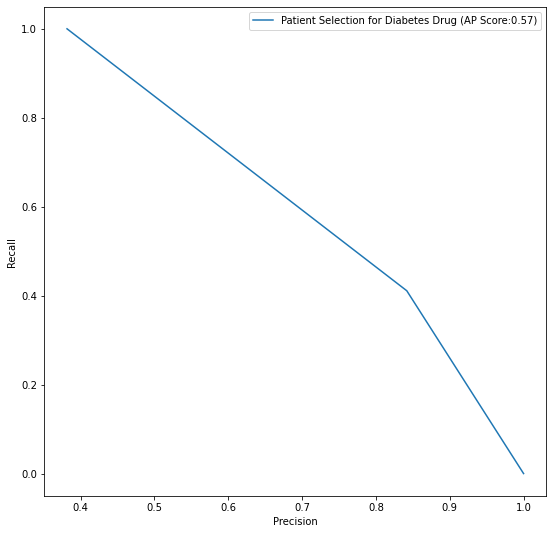

In [67]:
# shifting the decision boundary can either increase the precision or recall but not both
# in other words, increasing one parameter leads to decreasing of the other
# F1 score is a weighted average of precision and recall and helps to balance the two

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Patient Selection for Diabetes Drug', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Precision')
    c_ax.set_ylabel('Recall')
    
plot_pr(y_true, y_pred)

## Part 4. Evaluating Potential Model Biases with Aequitas Toolkit

### Prepare Data For Aequitas Bias Toolkit 

In [68]:
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [2092]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


In [69]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,2092,race,AfricanAmerican,396,1669,67,472,1197,329,801,1264,2065,11227
1,1,binary 0/1,2092,race,Asian,13,60,5,15,45,8,23,50,73,11227
2,1,binary 0/1,2092,race,Caucasian,1562,6831,240,1894,4937,1322,3216,5177,8393,11227
3,1,binary 0/1,2092,race,Hispanic,30,192,6,46,146,24,70,152,222,11227
4,1,binary 0/1,2092,race,Other,39,141,8,29,112,31,60,120,180,11227
5,1,binary 0/1,2092,race,nan,52,242,5,67,175,47,114,180,294,11227
6,1,binary 0/1,2092,gender,Female,1138,4805,181,1365,3440,957,2322,3621,5943,11227
7,1,binary 0/1,2092,gender,Male,954,4329,150,1158,3171,804,1962,3321,5283,11227
8,1,binary 0/1,2092,gender,Unknown/Invalid,0,1,0,0,1,0,0,1,1,11227


In [70]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,AfricanAmerican,0.41,0.95,0.28,0.17,0.05,0.59,0.72,0.83,0.19,0.19,0.39
1,race,Asian,0.35,0.90,0.25,0.38,0.10,0.65,0.75,0.62,0.01,0.18,0.32
2,race,Caucasian,0.41,0.95,0.28,0.15,0.05,0.59,0.72,0.85,0.75,0.19,0.38
3,race,Hispanic,0.34,0.96,0.24,0.20,0.04,0.66,0.76,0.80,0.01,0.14,0.32
4,race,Other,0.52,0.93,0.21,0.21,0.07,0.48,0.79,0.79,0.02,0.22,0.33
5,race,nan,0.41,0.97,0.28,0.10,0.03,0.59,0.72,0.90,0.02,0.18,0.39
6,gender,Female,0.41,0.95,0.28,0.16,0.05,0.59,0.72,0.84,0.54,0.19,0.39
7,gender,Male,0.41,0.95,0.27,0.16,0.05,0.59,0.73,0.84,0.46,0.18,0.37
8,gender,Unknown/Invalid,NaN,1.00,0.00,NaN,0.00,NaN,1.00,NaN,0.00,0.00,0.00


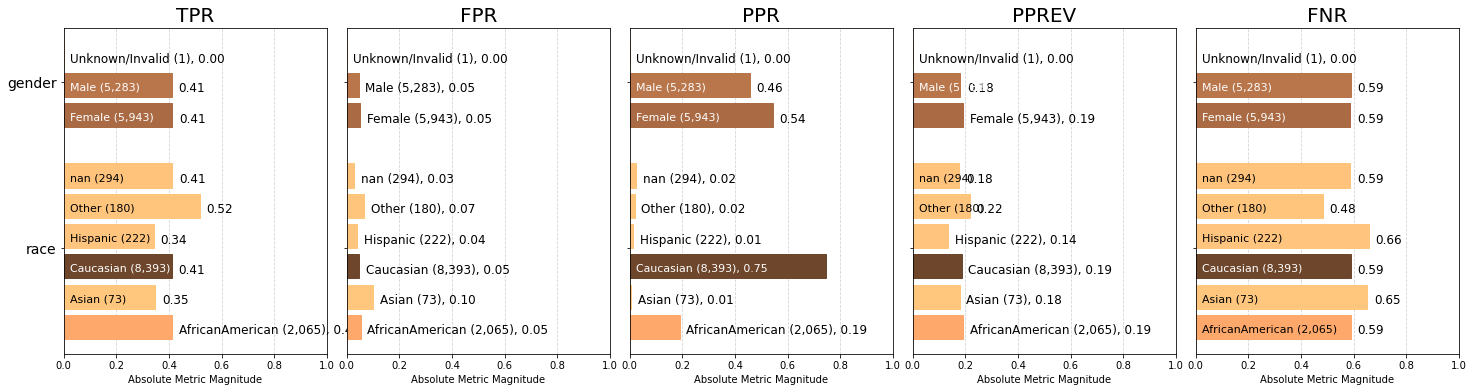

In [71]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

### Reference Group Selection

In [72]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


### Race and Gender Bias Analysis for Patient Selection

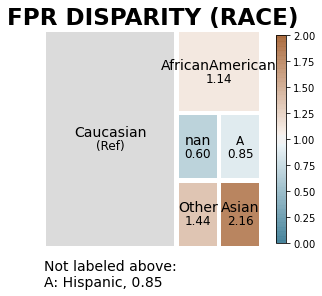

In [73]:
# Others are less likely to be falsely identified compared to Caucasians
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

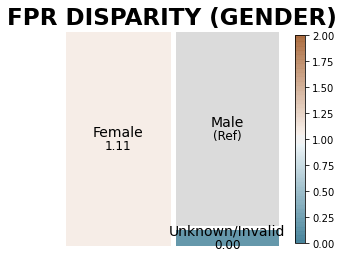

In [74]:
# females are 1.04X likely to be falsely identified compared to males
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

### Fairness Analysis - Relative to a Reference Group 

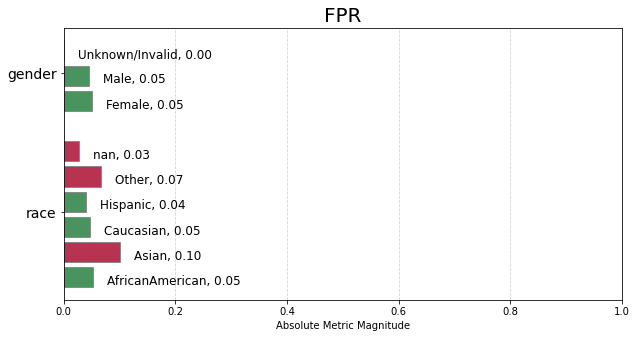

In [75]:
# Compared to Caucasians, other race groups have lower false positive rates. 
# Compared to males, females have a slightly higher false positive rate. 
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

## Part 5. Alternative Models

### Naive Performance
This is to assume that all of the patients are eligible for the diabetes drug testing. 

In [76]:
# Calculate accuracy, precision and recall
accuracy = y_train.mean()
recall = 1
precision = y_train.mean()

# Calculate F1-score 

fscore = 2*(recall * precision)/(precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3816, F-score: 0.5524]


### Creating a Training and Predicting Pipeline

In [77]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end -start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # alculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

LogisticRegression trained on 168 samples.
LogisticRegression trained on 1683 samples.
LogisticRegression trained on 16839 samples.
DecisionTreeClassifier trained on 168 samples.
DecisionTreeClassifier trained on 1683 samples.
DecisionTreeClassifier trained on 16839 samples.
GradientBoostingClassifier trained on 168 samples.
GradientBoostingClassifier trained on 1683 samples.
GradientBoostingClassifier trained on 16839 samples.


/home/workspace/starter_code/visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


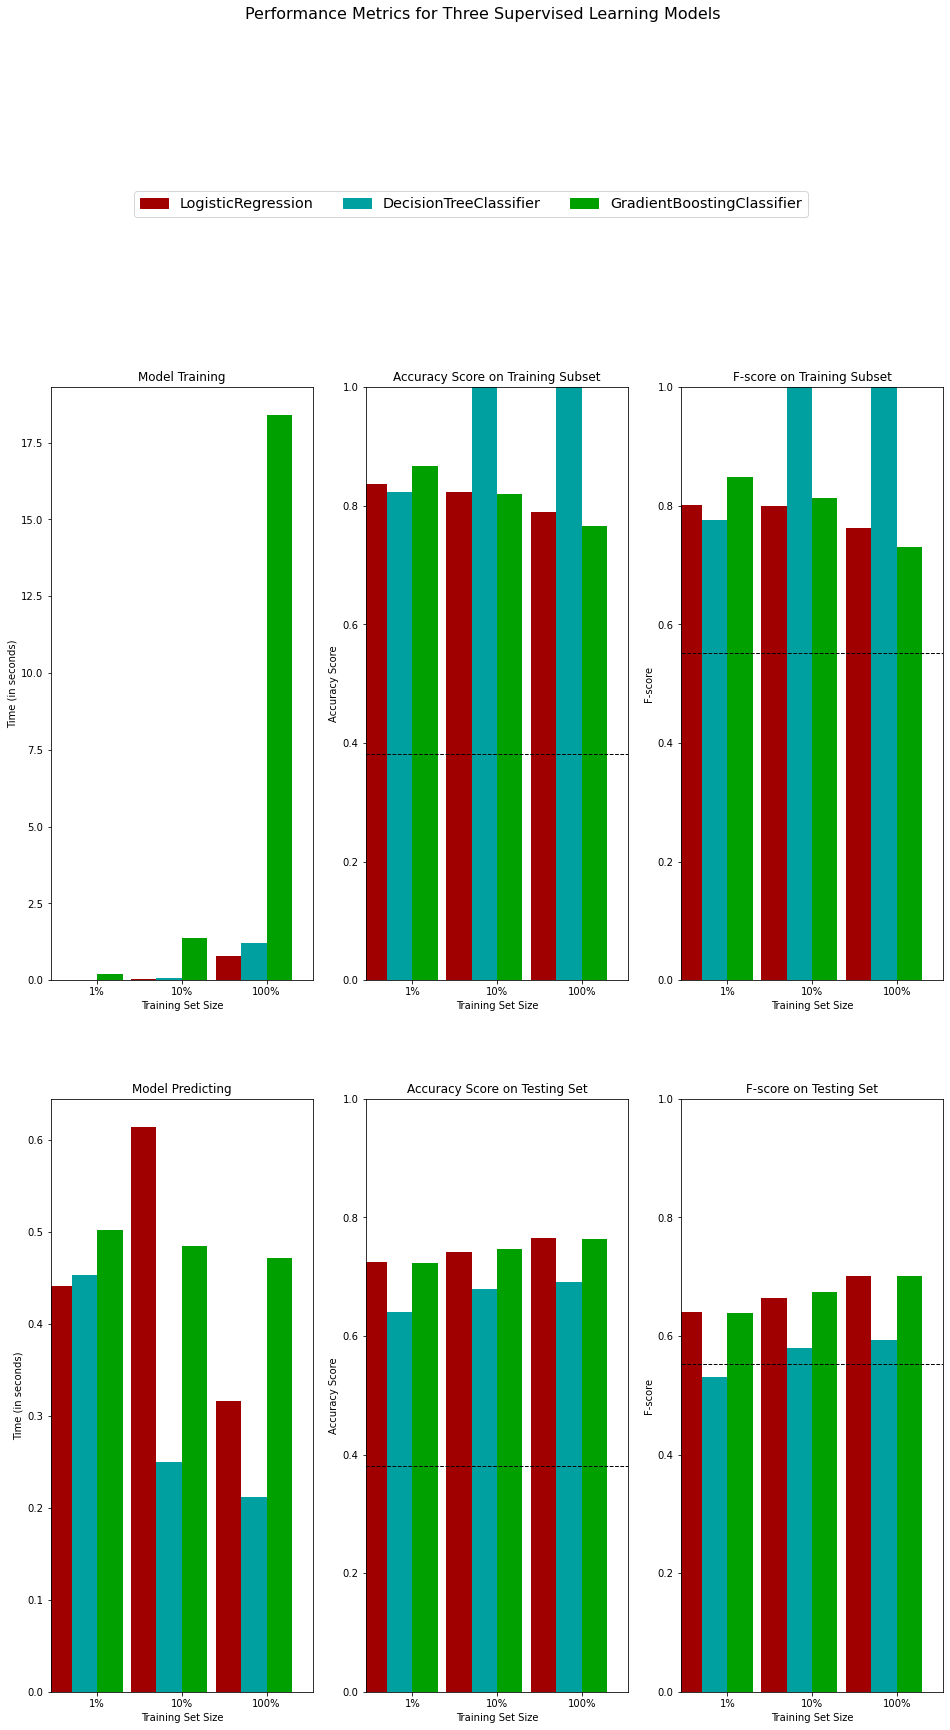

In [78]:
# Initialize three models
clf_A = LogisticRegression(random_state = 1, solver = 'liblinear')
clf_B = DecisionTreeClassifier()
clf_C = GradientBoostingClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(samples_100 *0.1)
samples_1 = int(samples_100 *0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Model Tuning

In [79]:
best_clf = LogisticRegression(random_state = 1, solver = 'liblinear')
best_clf.fit(X_train, y_train)
best_predictions = best_clf.predict(X_test)

print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))

Final accuracy score on the testing data: 0.7652
Final F-score on the testing data: 0.6664


### Bias-variance Tradeoff 

In [80]:
def learning_curves(estimator, X, y):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, 
                                                                  X, 
                                                                  y,
                                                                  scoring='f1')
    train_scores_mean = train_scores.mean(axis = 1)
    print(train_scores_mean)
    validation_scores_mean = validation_scores.mean(axis = 1)
    print(validation_scores_mean)

    plt.plot(train_sizes, train_scores_mean, label = 'Training')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation')

    plt.ylabel('F1', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)    

[0.78869083 0.73498026 0.7176713  0.70829229 0.7020134 ]
[0.65683178 0.66689494 0.67049771 0.67154677 0.67488191]


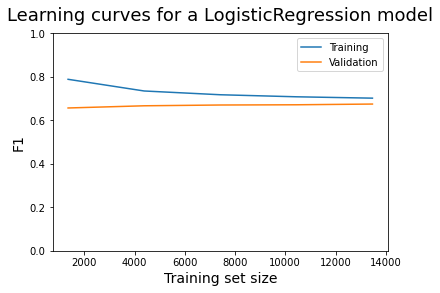

In [81]:
learning_curves(LogisticRegression(random_state = 1, solver = 'liblinear'), X_train, y_train)

### Extracting Feature Importance

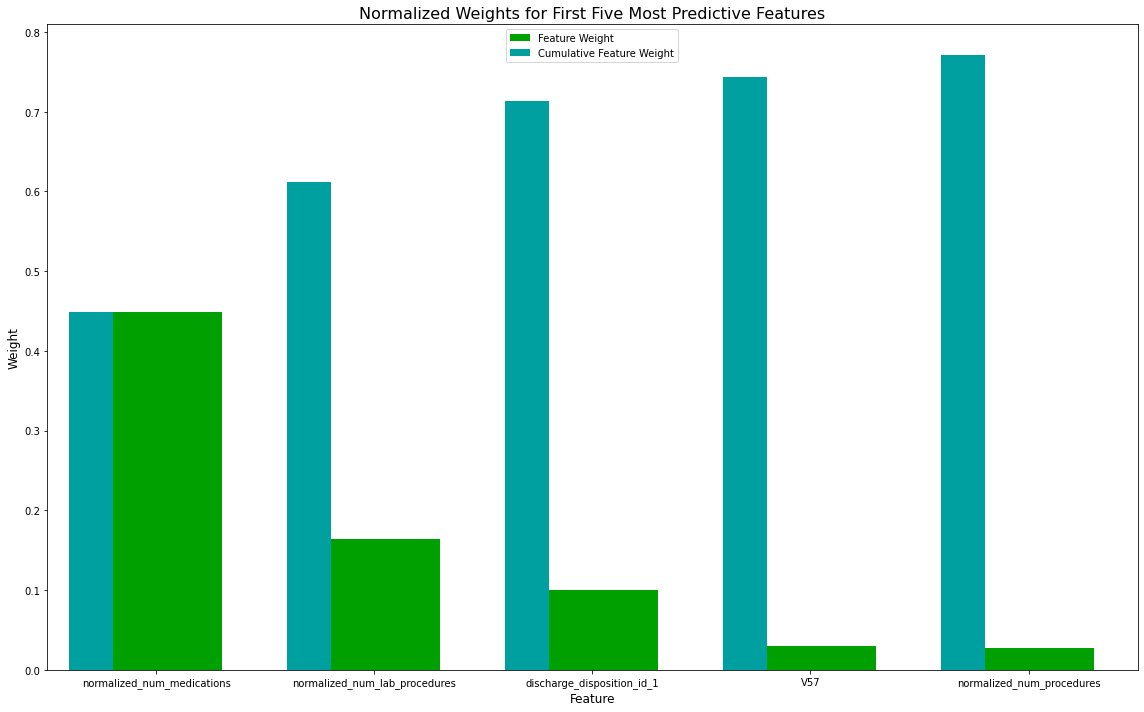

In [82]:
# Extract the feature importances using .feature_importances_ 
importances = clf_C.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [83]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7652
F-score on testing data: 0.7019

Final Model trained on reduced data
------
Accuracy on testing data: 0.7381
F-score on testing data: 0.6641
